# Trabalho Prático 1: Compressão de Imagens

**Grupo**:

- Isis Ferreira Carvalho (2020006663)
- Lucas Mesquita Andrade (2020054668)
- Victor Augusto de Lima Cruz (2020054854)

## Objetivo

O objetivo do trabalho foi explorar a performance de alguns métodos de codificação e comparar seu funcionamento e qualidade de compressão. Para isso, escolhemos alguns métodos, tentando combinar os conteúdos vistos em aula e incorporando elementos encontrados em coisas que estudamos por fora. 

Nesse sentido, para este trabalho, implementamos 2 métodos de compressão distintos e parametrizáveis:

- JPEG

- Wavelet (inspirado no JPEG 2000)

Testamos os métodos implementados em um pequeno dataset de imagens .pgm e obtivemos médias de performance para PSNR e taxa de compressão. 

Ao fim do trabalho, para facilitar a execução, implementamos uma função parametrizável para que o professor possa testar qualquer um dos métodos com suas próprias imagens e obter o resultado da codificação.

## Implementação

In [1]:
# Importações
%matplotlib inline
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack
import matplotlib.image as mpimg
from collections import Counter
import heapq
import struct
import json
import warnings
import pywt
import math

warnings.simplefilter(action='ignore', category=FutureWarning)

### Huffman

In [2]:
""" 
    Lógica da Codificação de Huffman, com métodos de codificação e decodificação 
"""

# Calcula frequências dos tons de cinza 
def calculate_frequencies(arr):
    flattened = arr.flatten()
    return Counter(flattened)

# Classe que implementa o nó da árvore para Codificação de Huffman
class HuffmanNode:
    def __init__(self, value=None, freq=0):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

# Constrói árvore de Huffman usando heap e pegando elemento mínimo para fazer merge de nodes
def build_huffman_tree(frequencies):
    heap = [HuffmanNode(value, freq) for value, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(freq=node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

# Gera os códigos atrelados a cada um dos tons de cinza da imagem
def generate_huffman_codes(node, prefix='', codebook=None):
    if codebook is None:
        codebook = {}
    if node.value is not None:
        codebook[node.value] = prefix
    else:
        generate_huffman_codes(node.left, prefix + '0', codebook)
        generate_huffman_codes(node.right, prefix + '1', codebook)
    return codebook

# Codifica o array usando as novas representações para cada um dos tons de cinza
def encode_array(arr, codebook):
    flattened = arr.flatten()
    encoded_bits = ''.join(codebook[value] for value in flattened)
    return encoded_bits

# Salva os dados codificados em um arquivo binário
def save_encoded_data(encoded_bits, codebook, original_shape, file_path):
    with open(file_path, 'wb') as f:
        # Salva o formato original da imagem
        f.write(struct.pack('>II', *original_shape))
        codebook_converted = {int(k): v for k, v in codebook.items()}
        
        # Salva a relação de códigos e tons de cinza
        codebook_str = json.dumps(codebook_converted)
        f.write(struct.pack('>I', len(codebook_str)))
        f.write(codebook_str.encode('utf-8'))
        
        # Salva o tamanho da sequência de bits codificada
        bitstream_len = len(encoded_bits)
        f.write(struct.pack('>I', bitstream_len))
        
        # Salva a sequência de bits codificada
        byte_array = bytearray()
        for i in range(0, bitstream_len, 8):
            byte = encoded_bits[i:i+8]
            byte_array.append(int(byte.ljust(8, '0'), 2))
        f.write(byte_array)

# Lê e carrega os dados do arquivo codificado
def load_encoded_data(file_path):
    with open(file_path, 'rb') as f:
        # Lê o formato original da imagem
        original_shape = struct.unpack('>II', f.read(8))
        
        # Lê a relação de códigos e tons de cinza
        codebook_len = struct.unpack('>I', f.read(4))[0]
        codebook_str = f.read(codebook_len).decode('utf-8')
        codebook = json.loads(codebook_str)
        
        # Lê o tamanho da sequência de bits codificada
        bitstream_len = struct.unpack('>I', f.read(4))[0]
        
        # Lê a sequência de bits codificada
        bitstream_bytes = f.read()
        encoded_bits = ''.join(format(byte, '08b') for byte in bitstream_bytes)[:bitstream_len]
    
    return encoded_bits, codebook, original_shape

# Decodifica a sequência de bits codificada,
# de acordo com a relação de códigos e tons de cinza salva na etapa de codificação
def decode_huffman(encoded_bits, codebook):
    reverse_codebook = {v: k for k, v in codebook.items()}
    decoded_values = []
    
    current_bits = ''
    for bit in encoded_bits:
        current_bits += bit
        if current_bits in reverse_codebook:
            decoded_values.append(reverse_codebook[current_bits])
            current_bits = ''
    
    return decoded_values

# Converte a sequência de bits para um array com o formato original
def bits_to_array(decoded_values, original_shape):
    return np.array(decoded_values).reshape(original_shape)

### JPEG

Algoritmo inspirado na codificação JPEG ensinada em aula. A codificação por entropia escolhida na nossa implementação foi Huffman, e as funções implementadas são parametrizadas de forma a possibilitar com que se possa utilizar qualquer matriz de quantização e função de transformada que se queira.

Fizemos experimentos com a DCT (Discrete Cosine Transform) e a DST (Discrete Sine Transform).

In [3]:
"""
    Função que faz o padding da imagem caso sua altura ou largura não sejam múltiplos de 8.
"""
def pad_image(img, block_size):

    width, height = img.shape[0], img.shape[1]

    if width % 8 != 0 or height % 8 != 0:
        height = np.float32(height) 
        width = np.float32(width) 

        new_width = np.int32(math.ceil(width/block_size) * block_size)
        new_height = np.int32(math.ceil(height/block_size) * block_size)

        padded_img = np.zeros((new_width, new_height))
        padded_img[0:int(width),0:int(height)] = img[0:int(width),0:int(height)]

        width, height = new_width, new_height
        cv2.imwrite(f'padded_img.bmp', np.uint8(padded_img))
    else:
        padded_img = img

    return padded_img, width, height

In [4]:
"""
    Funções de aplicação de transformadas e suas inversas.
"""
def apply_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def apply_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def apply_dst(img):
    return fftpack.dst(fftpack.dst(img.T, norm='ortho').T, norm='ortho')

def apply_idst(coefficients):
    return fftpack.idst(fftpack.idst(coefficients.T, norm='ortho').T, norm='ortho')

In [5]:
"""
    Função de caminhamento em zigzag na matriz pós-transformada e quantização, 
    para captar maiores coeficientes primeiro.
"""
def zigzag(input):
    h, v = 0, 0
    vmin, hmin = 0, 0
    vmax = input.shape[0]
    hmax = input.shape[1]
    i = 0

    output = np.zeros((vmax * hmax))

    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:                          # Subindo
            if (v == vmin):                             # Primeira linha
                output[i] = input[v, h]
                if (h == hmax):
                    v += 1
                else:
                    h += 1
                i += 1
            elif ((h == hmax - 1) and (v < vmax)):      # Última coluna
                output[i] = input[v, h]
                v += 1
                i += 1
            elif ((v > vmin) and (h < hmax - 1)):       # Demais casos
                output[i] = input[v, h]
                v -= 1
                h += 1
                i += 1
        else:                                           # Descendo
            if ((v == vmax - 1) and (h <= hmax - 1)):   # Última linha
                output[i] = input[v, h]
                h += 1
                i += 1
            elif (h == hmin):                           # Primeira coluna
                output[i] = input[v, h]
                if (v == vmax - 1):
                    h += 1
                else:
                    v += 1
                i = i + 1
            elif ((v < vmax - 1) and (h > hmin)):       # Demais casos
                output[i] = input[v, h]
                v += 1
                h -= 1
                i += 1

        if ((v == vmax - 1) and (h == hmax - 1)):           # Último elemento da matriz
            output[i] = input[v, h]
            break

    return output.astype(int)

def unzigzag(input, vmax, hmax):
    h, v = 0, 0
    vmin, hmin = 0, 0
    i = 0
    
    output = np.zeros((vmax, hmax))
    
    while ((v < vmax) and (h < hmax)): 
        if ((h + v) % 2) == 0:
            if (v == vmin):
                output[v, h] = input[i]
                if (h == hmax):
                    v += 1
                else:
                    h += 1                        
                i += 1
            elif ((h == hmax - 1) and (v < vmax)):
                output[v, h] = input[i] 
                v += 1
                i += 1
            elif ((v > vmin) and (h < hmax - 1)):
                output[v, h] = input[i] 
                v -= 1
                h += 1
                i += 1
        else:                                   
            if ((v == vmax - 1) and (h <= hmax - 1)):
                output[v, h] = input[i] 
                h += 1
                i += 1
            elif (h == hmin):
                output[v, h] = input[i] 
                if (v == vmax - 1):
                    h += 1
                else:
                    v+= 1
                i += 1                
            elif((v < vmax - 1) and (h > hmin)):
                output[v, h] = input[i] 
                v += 1
                h -= 1
                i += 1
        if ((v == vmax - 1) and (h == hmax - 1)):     
            output[v, h] = input[i] 
            break
        
    return output

In [6]:
"""
    Declaração da matriz de quantização a ser usada na codificação
"""
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

In [7]:
""" 
    Função que aplica todo o fluxo de codificação JPEG:
    - Normalização dos tons de cinza e padding da imagem;
    - DCT, quantização e zigzag por bloco da imagem
    - Construção da representação codificada da imagem com Huffman, representação essa que é salva em um arquivo .bin
    
    Recebe:
    img                  Matriz da imagem.
    transformada         Função de transformada a ser aplicada.
    quantiz_matrix       Matriz de quantização a ser aplicada após a transformada.
    encoded_file_path    Caminho onde o arquivo compactado será salvo
    (plot)               Booleano que indica se imprimirá resultado do encoding

    Retorna o array resultado dos processamentos, logo antes da codificação Huffman.
"""
def encode_jpeg(img, transformada, quantiz_matrix, encoded_file_path='encoded_image.bin', plot=False):
    img = img.astype(float)
    img = img - 128
    block_size = 8
    padded_img, width, height = pad_image(img, block_size)

    new_img = np.zeros((width, height)).astype(int) # Para guardar representação pós transformada, quantização e zigzag

    for x in range(0, width, block_size):
        for y in range(0, height, block_size):
            block = padded_img[x:x+block_size, y:y+block_size]
            dct = transformada(block)
            dct_quantized = np.round(np.divide(dct, quantiz_matrix)).astype(int)
            dct_zigzag = zigzag(dct_quantized)
            reshaped = np.reshape(dct_zigzag, (block_size, block_size))
            new_img[x:x+block_size, y:y+block_size] = reshaped

    # Huffman
    arr = np.array(new_img)
    frequencies = calculate_frequencies(arr)
    huffman_tree = build_huffman_tree(frequencies)
    codebook = generate_huffman_codes(huffman_tree)
    encoded_bits = encode_array(arr, codebook)
    save_encoded_data(encoded_bits, codebook, img.shape, encoded_file_path)

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(12,8))
        ax = ax.flatten()
        ax[0].imshow(img+128, cmap = 'gray', clim=(0, 255))
        ax[0].set_title('Imagem original')
        ax[1].imshow(new_img+100, cmap = 'gray', clim=(0, 255))
        ax[1].set_title('Resultado da transformada')
        plt.show()

    return new_img

In [8]:
""" 
    Função que aplica todo o fluxo de decodificação JPEG:
    - Lê e processa os dados codificados
    - Reverte o processo de decodificação JPEG
    
    Recebe:
    encoded_file_path    Caminho onde o arquivo compactado está salvo.
    transformada         Função de transformada aplicada na compressão.
    quantiz_matrix       Matriz de quantização aplicada na compressão após a transformada.
    (plot)               Booleano que indica se imprimirá resultado da reconstrução
    
    Retorna a imagem reconstruída.
"""
def decode_jpeg(encoded_file_path, transformada, quantiz_matrix, plot=False):
    encoded_bits_read, codebook_read, original_shape_read = load_encoded_data(encoded_file_path)
    (orig_w, orig_h) = original_shape_read

    if orig_w % 8 != 0:
        padded_w = orig_w + 8 - (orig_w % 8)
    else:
        padded_w = orig_w
    if orig_h % 8 != 0:
        padded_h = orig_h + 8 - (orig_h % 8)
    else:
        padded_h = orig_h
            
    codebook_treated = {int(k):v for k,v in codebook_read.items()}
    decoded_values = decode_huffman(encoded_bits_read, codebook_treated)
    reconst_matrix = bits_to_array(decoded_values, (padded_w, padded_h))     # Final da decodificação de Huffman

    reconst_img = np.zeros((padded_w, padded_h)).astype(int)

    block_size = 8
    for x in range(0, padded_w, block_size):
        for y in range(0, padded_h, block_size):
            block = reconst_matrix[x:x+block_size, y:y+block_size]
            block = unzigzag(block.flatten(), block_size, block_size)
            reconst_dequantized = np.multiply(block, quantiz_matrix).astype(int)
            inverse_dct = transformada(reconst_dequantized)
            reconst_img[x:x+block_size, y:y+block_size] = inverse_dct

    reconst_img = reconst_img[:orig_w, :orig_h]
    reconst_img += 128

    reconst_img = np.uint8(reconst_img)

    if plot:
        plt.imshow(reconst_img, cmap = 'gray', clim=(0, 255))
        plt.title('Imagem reconstruída')
        plt.show()

    return reconst_img

### Wavelet

Algoritmo inspirado no JPEG 2000 que utiliza a transformada Wavelets para comprimir o arquivo.

O algoritmo faz a DWT (Discrete Wavelet Trasform) bidimensional na imagem gerando quatro matrizes de coeficientes (A H V D), a primeira contendo informações de baixa frequência e as três últimas contendo informações de alta frequência na horizontal, vertical e diagonal. 

Após a DWT, os coeficientes são limitados por um threshold e arredondados para ocuparem menos espaço em memória. O threshold é definido como sendo o x-percentil dos coeficientes sendo limitados. Ou seja, para o 90-percentil, os 90% menores coeficientes serão removidos de consideração. Por último, depois de arredondados, utilizamos Huffman para explorar a redundância de codificação, visto que x% dos coeficientes filtrados é 0.

Foram criadas duas variantes desse algoritmo de codificação: o Wavelet e o WaveletAll.

- **Wavelet**<br>
Utiliza todos os coeficientes A, visto que são de baixa frequência e trazem informação importante. Limita apenas os coeficientes de detalhes H V e D, considerando apenas eles para calcular o percentil.

- **WaveletAll**<br>
Limita todos os coeficientes considerando todos eles para calcular o percentil.

**Considerações**:<br>

O percentil 0 não é uma compressão sem perdas devido ao arredondamento dos coeficientes.<br>

O decodificador das duas é o mesmo, visto que o thresholding é o que diferencia os dois métodos e não é recuperável, portanto não faz parte do processo de decodificação.<br>

Por filtrar todos os parâmetros para se ter um resultado comparável entre os algoritmos, é necessário usar valores menores de percentil no WaveletAll.

In [9]:
def encodeHuffmanWavelet(img, encoded_file_path, shape):
  arr = np.array(img)
  frequencies = calculate_frequencies(arr)
  huffman_tree = build_huffman_tree(frequencies)
  codebook = generate_huffman_codes(huffman_tree)
  encoded_bits = encode_array(arr, codebook)
  save_encoded_data(encoded_bits, codebook, shape, encoded_file_path)

def decodeHuffmanWavelet(encoded_file_path):
    encoded_bits_read, codebook_read, original_shape_read = load_encoded_data(encoded_file_path)
    (orig_w, orig_h) = original_shape_read

    if orig_w % 8 != 0:
        padded_w = orig_w + 8 - (orig_w % 8)
    else:
        padded_w = orig_w
    if orig_h % 8 != 0:
        padded_h = orig_h + 8 - (orig_h % 8)
    else:
        padded_h = orig_h

    padded_h = int(padded_h / 2)
    padded_w = int(padded_w * 2)

    codebook_treated = {int(k):v for k,v in codebook_read.items()}
    decoded_values = decode_huffman(encoded_bits_read, codebook_treated)
    reconst_matrix = bits_to_array(decoded_values, (padded_w, padded_h))

    return reconst_matrix, original_shape_read

In [10]:

""" 
    Função que aplica todo o fluxo de codificação do algoritmo Wavelet proposto:
    - Padding da imagem;
    - DWT e thresholding dos coeficientes de detalhe (H V D) da imagem como um todo;
    - Concatenação vertical das matrizes de coeficiente A H V D que serão salvas;
    - Construção da representação codificada dos coeficientes com Huffman, representação essa que é salva em um arquivo passado como parâmetro.
    
    Recebe:
    img                     Matriz da imagem.
    encoded_file_path       Caminho onde o arquivo compactado será salvo
    percentile_threshold    Percentil dos coeficientes que será filtrado.
    
"""
def compressWavelet(img, encoded_file_path, percentile_threshold = 90):
  padded_img, _, _ = pad_image(img, 8)

  coeffs = pywt.dwt2(padded_img, 'haar')
  cA, (cH, cV, cD) = coeffs

  allCoef = np.abs(np.concatenate((cH.flatten(), cV.flatten(), cD.flatten())))
  threshold = np.percentile(allCoef, percentile_threshold)

  cH_thresholded = pywt.threshold(cH, threshold, mode='hard')
  cV_thresholded = pywt.threshold(cV, threshold, mode='hard')
  cD_thresholded = pywt.threshold(cD, threshold, mode='hard')

  cA = cA.astype(int)
  cH_thresholded = cH_thresholded.astype(int)
  cV_thresholded = cV_thresholded.astype(int)
  cD_thresholded = cD_thresholded.astype(int)

  result = np.vstack((cA, cH_thresholded, cV_thresholded, cD_thresholded))

  encodeHuffmanWavelet(result, encoded_file_path, img.shape)

""" 
    Função que aplica todo o fluxo de decodificação Wavelet:
    - Lê e decodifica a representação Huffman gerada na compressão;
    - Utiliza as matrizes comprimidas na inversa da função de WDT;
    - Remove o padding.
    
    Recebe:
    encoded_file_path    Caminho onde o arquivo compactado está salvo.
    transformada         Função de transformada aplicada na compressão.
    quantiz_matrix       Matriz de quantização aplicada na compressão após a transformada.
    (plot)               Booleano que indica se imprimirá resultado da reconstrução.
    
    Retorna a imagem reconstruída.
"""
def decompressWavelet(encoded_file_path):
    allComponents, orig_size = decodeHuffmanWavelet(encoded_file_path)

    size = int(allComponents.shape[0]/4)

    cA = allComponents[:size, :]
    cH = allComponents[size:size*2, :]
    cV = allComponents[size*2:size*3, :]
    cD = allComponents[size*3:, :]

    coeffs_thresholded = (cA, (cH, cV, cD))
    img_decompressed = pywt.idwt2(coeffs_thresholded, 'haar')


    img_decompressed = img_decompressed[:orig_size[0], :orig_size[1]]

    return img_decompressed

In [11]:
""" 
    Função que aplica todo o fluxo de codificação do algoritmo WaveletAll proposto:
    - Padding da imagem;
    - DWT e thresholding de todos os coeficientes (A H V D) da imagem como um todo;
    - Concatenação vertical das matrizes de coeficiente A H V D que serão salvas;
    - Construção da representação codificada dos coeficientes com Huffman, representação essa que é salva em um arquivo passado como parâmetro
    
    Recebe:
    img                     Matriz da imagem.
    encoded_file_path       Caminho onde o arquivo compactado será salvo.
    percentile_threshold    Percentil dos coeficientes que será filtrado.
    
"""
def compressWaveletAll(img, encoded_file_path, percentile_threshold = 60):
  padded_img, _, _ = pad_image(img, 8)

  coeffs = pywt.dwt2(padded_img, 'haar')
  cA, (cH, cV, cD) = coeffs

  allCoef = np.abs(np.concatenate((cH.flatten(), cV.flatten(), cD.flatten(), cA.flatten())))
  threshold = np.percentile(allCoef, percentile_threshold)

  cA_thresholded = pywt.threshold(cA, threshold, mode='hard')

  cH_thresholded = pywt.threshold(cH, threshold, mode='hard')
  cV_thresholded = pywt.threshold(cV, threshold, mode='hard')
  cD_thresholded = pywt.threshold(cD, threshold, mode='hard')

  cA_thresholded = cA_thresholded.astype(int)
    
  cH_thresholded = cH_thresholded.astype(int)
  cV_thresholded = cV_thresholded.astype(int)
  cD_thresholded = cD_thresholded.astype(int)

  result = np.vstack((cA_thresholded, cH_thresholded, cV_thresholded, cD_thresholded))

  encodeHuffmanWavelet(result, encoded_file_path, img.shape)


# Experimentos

A seguinte sessão de experimentos foi organizada da seguinte maneira:

Juntamos 33 imagens .pgm usados em datasets de imagens e, para cada um dos métodos de compressão implementados, rodamos a compressão para todas essas imagens, obtivemos o PSNR e a taxa de compressão para cada uma delas e calculamos, ao fim, a média e o desvio padrão de ambas as métricas de qualidade de compressão. Assim, foi possível testar os métodos de compressão usando o mesmo conjunto de dados, e compará-los de forma justa.

Os experimentos esperam um diretório img com as imagens em pgm a serem testadas.

Rodar novamente removerá os resultados para as imagens que foram executados.

## Funções auxiliares dos experimentos

In [12]:
# Implementação do Professor
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

In [13]:
# Funções auxiliares para codificação JPEG com DCT
def aux_jpeg_encode_dct(img, output_filepath):
    encode_jpeg(img, apply_dct, QM, output_filepath)

def aux_jpeg_decode_dct(output_filepath):
    return decode_jpeg(output_filepath, apply_idct, QM)

# Funções auxiliares para codificação JPEG com DST
def aux_jpeg_encode_dst(img, output_filepath):
    encode_jpeg(img, apply_dst, QM, output_filepath)

def aux_jpeg_decode_dst(output_filepath):
    return decode_jpeg(output_filepath, apply_idst, QM)

In [14]:
# Funções auxiliares para codificação Wavelet
def createCompressWaveletWithPercentile(percentile):
    def compress(img, encoded_file_path):
        compressWavelet(img, encoded_file_path, percentile)
    return compress

def createCompressWaveletAllWithPercentile(percentile):
    def compress(img, encoded_file_path):
        compressWaveletAll(img, encoded_file_path, percentile)
    return compress

In [15]:
"""
    Função que, para um determinado método de compressão (passado como parâmetro), itera por todas as imagens de
    teste, faz a compressão e descompressão dessas imagens, calcula o PSNR e a taxa de compressão, e salva essas
    métricas em um DataFrame.
"""
def evaluateCompression(compressionFunction, decompressionFunction):
    files = os.listdir('img')
    df = pd.DataFrame()
    for file in files:
        input_filepath = './img/' + file

        filename = os.path.splitext(file)[0]
        output_filepath = './tmp/' + filename + ".bin"
        
        imageMatrix = cv2.imread(input_filepath, 0)
        if imageMatrix is None:
            continue

        compressionFunction(imageMatrix, output_filepath)
        decompressedImageMatrix = decompressionFunction(output_filepath)
        compression_rate = os.path.getsize(input_filepath) / os.path.getsize(output_filepath)
        psnr_imgs = psnr(imageMatrix, decompressedImageMatrix)
        
        df = df.append({'file': file, 
                        'shape': imageMatrix.shape,
                        'result_shape': imageMatrix.shape,
                        'compression_rate': compression_rate,
                        'psnr': psnr_imgs
                       }, ignore_index=True)
        
    return df
    

In [16]:
# DataFrame que conterá as métricas por método de compressão
compare_df = pd.DataFrame()

## JPEG com DCT

In [17]:
evaluation_df = evaluateCompression(aux_jpeg_encode_dct, aux_jpeg_decode_dct)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'jpeg-dct', 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 36.55 ± 3.86
Compression Rate - 5.07 ± 0.71


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",6.235749,34.836174
1,barbara.pgm,"(512, 512)","(512, 512)",4.757258,34.070900
2,boats.pgm,"(576, 720)","(576, 720)",5.355932,36.301283
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",6.773264,41.803347
4,Brain1.pgm,"(911, 699)","(911, 699)",5.134791,40.388619
5,Brain2.pgm,"(901, 675)","(901, 675)",5.350173,41.372263
6,Brain3.pgm,"(867, 691)","(867, 691)",5.024319,39.784053
7,Brain4.pgm,"(881, 719)","(881, 719)",5.529411,42.816451
8,Brain5.pgm,"(903, 713)","(903, 713)",5.527885,42.861801
9,bridge.pgm,"(512, 512)","(512, 512)",4.103968,31.700034


## JPEG com DST

In [18]:
evaluation_df = evaluateCompression(aux_jpeg_encode_dst, aux_jpeg_decode_dst)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'jpeg-dst', 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 30.62 ± 0.63
Compression Rate - 4.24 ± 0.42


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",4.393360,29.946821
1,barbara.pgm,"(512, 512)","(512, 512)",4.136211,30.607819
2,boats.pgm,"(576, 720)","(576, 720)",4.682404,31.283235
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",4.573359,30.036530
4,Brain1.pgm,"(911, 699)","(911, 699)",4.086573,30.132359
5,Brain2.pgm,"(901, 675)","(901, 675)",4.294622,30.827134
6,Brain3.pgm,"(867, 691)","(867, 691)",4.012074,29.976970
7,Brain4.pgm,"(881, 719)","(881, 719)",4.196657,30.401478
8,Brain5.pgm,"(903, 713)","(903, 713)",4.187083,30.458895
9,bridge.pgm,"(512, 512)","(512, 512)",3.833855,30.190276


## Wavelet

### 100-percentil

In [19]:
# 100 perc
percentile = 100
evaluation_df = evaluateCompression(createCompressWaveletWithPercentile(percentile), decompressWavelet)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'wavelet' + str(percentile), 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 30.58 ± 4.78
Compression Rate - 2.5 ± 0.27


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",2.982073,34.369869
1,barbara.pgm,"(512, 512)","(512, 512)",2.326453,25.416889
2,boats.pgm,"(576, 720)","(576, 720)",2.507864,29.711833
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",3.127873,40.537825
4,Brain1.pgm,"(911, 699)","(911, 699)",2.613932,31.149341
5,Brain2.pgm,"(901, 675)","(901, 675)",2.737972,33.648557
6,Brain3.pgm,"(867, 691)","(867, 691)",2.578533,31.167884
7,Brain4.pgm,"(881, 719)","(881, 719)",2.663615,36.017064
8,Brain5.pgm,"(903, 713)","(903, 713)",2.679059,36.844850
9,bridge.pgm,"(512, 512)","(512, 512)",2.400824,25.680811


### 99-percentil

In [20]:
# 99 perc
percentile = 99
evaluation_df = evaluateCompression(createCompressWaveletWithPercentile(percentile), decompressWavelet)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'wavelet' + str(percentile), 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 33.21 ± 5.8
Compression Rate - 2.4 ± 0.27


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",2.887214,35.489076
1,barbara.pgm,"(512, 512)","(512, 512)",2.232894,26.935879
2,boats.pgm,"(576, 720)","(576, 720)",2.411692,33.040420
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",3.014008,44.390840
4,Brain1.pgm,"(911, 699)","(911, 699)",2.504619,34.900217
5,Brain2.pgm,"(901, 675)","(901, 675)",2.634907,36.968862
6,Brain3.pgm,"(867, 691)","(867, 691)",2.487575,34.110762
7,Brain4.pgm,"(881, 719)","(881, 719)",2.581480,38.314787
8,Brain5.pgm,"(903, 713)","(903, 713)",2.602375,38.729582
9,bridge.pgm,"(512, 512)","(512, 512)",2.303216,26.955107


### 95-percentil

In [21]:
# 95 perc
percentile = 95
evaluation_df = evaluateCompression(createCompressWaveletWithPercentile(percentile), decompressWavelet)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'wavelet' + str(percentile), 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 36.28 ± 5.87
Compression Rate - 2.2 ± 0.25


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",2.637046,37.189797
1,barbara.pgm,"(512, 512)","(512, 512)",2.049642,29.950639
2,boats.pgm,"(576, 720)","(576, 720)",2.215339,37.035468
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",2.775091,46.391719
4,Brain1.pgm,"(911, 699)","(911, 699)",2.306818,39.491759
5,Brain2.pgm,"(901, 675)","(901, 675)",2.404945,41.618351
6,Brain3.pgm,"(867, 691)","(867, 691)",2.293059,38.166470
7,Brain4.pgm,"(881, 719)","(881, 719)",2.387263,42.528660
8,Brain5.pgm,"(903, 713)","(903, 713)",2.409232,42.310451
9,bridge.pgm,"(512, 512)","(512, 512)",2.113706,29.119478


### 90-percentil

In [22]:
# 90 perc
percentile = 90
evaluation_df = evaluateCompression(createCompressWaveletWithPercentile(percentile), decompressWavelet)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'wavelet' + str(percentile), 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 38.64 ± 5.94
Compression Rate - 2.04 ± 0.23


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",2.422266,38.568951
1,barbara.pgm,"(512, 512)","(512, 512)",1.876280,32.807953
2,boats.pgm,"(576, 720)","(576, 720)",2.029963,40.126849
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",2.577817,48.023156
4,Brain1.pgm,"(911, 699)","(911, 699)",2.145130,42.418837
5,Brain2.pgm,"(901, 675)","(901, 675)",2.223814,44.458928
6,Brain3.pgm,"(867, 691)","(867, 691)",2.133049,41.070620
7,Brain4.pgm,"(881, 719)","(881, 719)",2.214738,45.888007
8,Brain5.pgm,"(903, 713)","(903, 713)",2.238809,45.368133
9,bridge.pgm,"(512, 512)","(512, 512)",1.951049,31.029211


### 80 percentil

In [23]:
# 80 perc
percentile = 80
evaluation_df = evaluateCompression(createCompressWaveletWithPercentile(percentile), decompressWavelet)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'wavelet' + str(percentile), 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 42.29 ± 6.1
Compression Rate - 1.81 ± 0.21


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",2.131065,40.908194
1,barbara.pgm,"(512, 512)","(512, 512)",1.635448,37.447270
2,boats.pgm,"(576, 720)","(576, 720)",1.788860,44.096415
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",2.303576,50.548171
4,Brain1.pgm,"(911, 699)","(911, 699)",1.901209,46.957482
5,Brain2.pgm,"(901, 675)","(901, 675)",1.978649,49.016045
6,Brain3.pgm,"(867, 691)","(867, 691)",1.890093,45.858495
7,Brain4.pgm,"(881, 719)","(881, 719)",1.991002,50.713355
8,Brain5.pgm,"(903, 713)","(903, 713)",2.007586,50.432141
9,bridge.pgm,"(512, 512)","(512, 512)",1.717413,34.216530


## WaveletAll

### 99-percentil

In [24]:
# 99 perc
percentile = 99
evaluation_df = evaluateCompression(createCompressWaveletAllWithPercentile(percentile), decompressWavelet)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'waveletAll' + str(percentile), 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 7.68 ± 3.65
Compression Rate - 7.3 ± 0.16


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",7.304324,18.018276
1,barbara.pgm,"(512, 512)","(512, 512)",7.330277,6.404702
2,boats.pgm,"(576, 720)","(576, 720)",7.327233,6.241424
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",7.156148,19.964062
4,Brain1.pgm,"(911, 699)","(911, 699)",7.466345,8.835617
5,Brain2.pgm,"(901, 675)","(901, 675)",7.181130,8.964418
6,Brain3.pgm,"(867, 691)","(867, 691)",7.257316,8.629680
7,Brain4.pgm,"(881, 719)","(881, 719)",7.405190,8.976227
8,Brain5.pgm,"(903, 713)","(903, 713)",7.215278,9.475918
9,bridge.pgm,"(512, 512)","(512, 512)",7.422206,6.751429


### 80-percentil

In [25]:
# 80 perc
percentile = 80
evaluation_df = evaluateCompression(createCompressWaveletAllWithPercentile(percentile), decompressWavelet)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'waveletAll' + str(percentile), 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 24.67 ± 8.74
Compression Rate - 2.89 ± 0.28


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",3.443448,29.048723
1,barbara.pgm,"(512, 512)","(512, 512)",2.751238,20.662695
2,boats.pgm,"(576, 720)","(576, 720)",3.053643,22.447053
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",3.550975,31.066902
4,Brain1.pgm,"(911, 699)","(911, 699)",2.706562,35.077759
5,Brain2.pgm,"(901, 675)","(901, 675)",2.733873,40.508514
6,Brain3.pgm,"(867, 691)","(867, 691)",2.673051,35.402206
7,Brain4.pgm,"(881, 719)","(881, 719)",2.752094,40.363599
8,Brain5.pgm,"(903, 713)","(903, 713)",2.761690,40.729206
9,bridge.pgm,"(512, 512)","(512, 512)",2.875496,19.826312


### 75-percentil

In [26]:
# 75 perc
percentile = 75
evaluation_df = evaluateCompression(createCompressWaveletAllWithPercentile(percentile), decompressWavelet)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'waveletAll' + str(percentile), 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 33.97 ± 7.02
Compression Rate - 2.41 ± 0.22


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",2.973776,34.648786
1,barbara.pgm,"(512, 512)","(512, 512)",2.291540,26.235652
2,boats.pgm,"(576, 720)","(576, 720)",2.464587,32.442642
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",3.086368,43.353097
4,Brain1.pgm,"(911, 699)","(911, 699)",2.444718,37.954654
5,Brain2.pgm,"(901, 675)","(901, 675)",2.430324,43.925541
6,Brain3.pgm,"(867, 691)","(867, 691)",2.408622,37.812547
7,Brain4.pgm,"(881, 719)","(881, 719)",2.478014,43.403991
8,Brain5.pgm,"(903, 713)","(903, 713)",2.466536,43.751407
9,bridge.pgm,"(512, 512)","(512, 512)",2.368979,26.508795


### 0-percentil

In [27]:
# 0 perc
percentile = 0
evaluation_df = evaluateCompression(createCompressWaveletAllWithPercentile(percentile), decompressWavelet)
cur_psnr = str(round(evaluation_df['psnr'].mean(), 2)) + " ± " + str(round(evaluation_df['psnr'].std(), 2))
cur_cr = str(round(evaluation_df['compression_rate'].mean(), 2)) + " ± " + str(round(evaluation_df['compression_rate'].std(), 2))
compare_df = compare_df.append({'name': 'waveletAll' + str(percentile), 
                    'psnr': cur_psnr,
                    'cr': cur_cr,
                   }, ignore_index=True)
print("PSNR -", cur_psnr)
print("Compression Rate -", cur_cr)
evaluation_df

PSNR - 54.94 ± 0.87
Compression Rate - 1.33 ± 0.26


,file,shape,result_shape,compression_rate,psnr
0,airplaneU2.pgm,"(1024, 1024)","(1024, 1024)",1.396581,54.958498
1,barbara.pgm,"(512, 512)","(512, 512)",1.107594,54.339373
2,boats.pgm,"(576, 720)","(576, 720)",1.322372,54.239374
3,bone_scint.pgm,"(1865, 1129)","(1865, 1129)",1.873999,55.261689
4,Brain1.pgm,"(911, 699)","(911, 699)",1.504164,55.957047
5,Brain2.pgm,"(901, 675)","(901, 675)",1.657902,56.086615
6,Brain3.pgm,"(867, 691)","(867, 691)",1.469228,55.963000
7,Brain4.pgm,"(881, 719)","(881, 719)",1.702213,56.553478
8,Brain5.pgm,"(903, 713)","(903, 713)",1.708177,56.530853
9,bridge.pgm,"(512, 512)","(512, 512)",1.097060,55.047464


## Comparação total dos resultados

In [28]:
compare_df

,name,psnr,cr
0,jpeg-dct,36.55 ± 3.86,5.07 ± 0.71
1,jpeg-dst,30.62 ± 0.63,4.24 ± 0.42
2,wavelet100,30.58 ± 4.78,2.5 ± 0.27
3,wavelet99,33.21 ± 5.8,2.4 ± 0.27
4,wavelet95,36.28 ± 5.87,2.2 ± 0.25
5,wavelet90,38.64 ± 5.94,2.04 ± 0.23
6,wavelet80,42.29 ± 6.1,1.81 ± 0.21
7,waveletAll99,7.68 ± 3.65,7.3 ± 0.16
8,waveletAll80,24.67 ± 8.74,2.89 ± 0.28
9,waveletAll75,33.97 ± 7.02,2.41 ± 0.22


In [29]:
compare_df['psnr_num'] = compare_df['psnr'].apply(lambda x: float(x.split(' ')[0]))
compare_df['cr_num'] = compare_df['cr'].apply(lambda x: float(x.split(' ')[0]))

In [30]:
compare_df

,name,psnr,cr,psnr_num,cr_num
0,jpeg-dct,36.55 ± 3.86,5.07 ± 0.71,36.55,5.07
1,jpeg-dst,30.62 ± 0.63,4.24 ± 0.42,30.62,4.24
2,wavelet100,30.58 ± 4.78,2.5 ± 0.27,30.58,2.50
3,wavelet99,33.21 ± 5.8,2.4 ± 0.27,33.21,2.40
4,wavelet95,36.28 ± 5.87,2.2 ± 0.25,36.28,2.20
5,wavelet90,38.64 ± 5.94,2.04 ± 0.23,38.64,2.04
6,wavelet80,42.29 ± 6.1,1.81 ± 0.21,42.29,1.81
7,waveletAll99,7.68 ± 3.65,7.3 ± 0.16,7.68,7.30
8,waveletAll80,24.67 ± 8.74,2.89 ± 0.28,24.67,2.89
9,waveletAll75,33.97 ± 7.02,2.41 ± 0.22,33.97,2.41


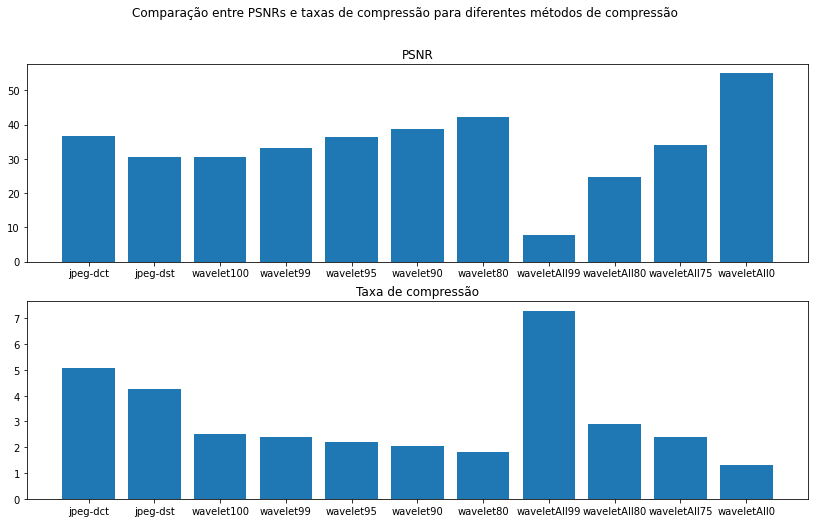

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(14, 8))
ax = ax.flatten()

ax[0].bar(x=list(range(len(compare_df))), height=compare_df['psnr_num'])
ax[0].set_xticks(list(range(len(compare_df))), compare_df['name'])
ax[0].set_title('PSNR')
ax[1].bar(x=list(range(len(compare_df))), height=compare_df['cr_num'])
ax[1].set_xticks(list(range(len(compare_df))), compare_df['name'])
ax[1].set_title('Taxa de compressão')

fig.suptitle('Comparação entre PSNRs e taxas de compressão para diferentes métodos de compressão')
plt.show()

Olhando o gráfico, é possível perceber que a maior taxa de compressão média atingida foi com o algoritmo waveletAll99 (7.30), porém a PSNR média atingida por esse algoritmo é 7.68, ou seja, perde-se muita informação e não é um bom método de compressão (veja um exemplo de execução desse algoritmo no apêndice do notebook). Isso já era de se esperar, visto que a WaveletAll99 joga 99% dos coeficientes também de baixa frequência fora. 

Podemos observar que a Wavelet tradicional, com os diferentes percentis sendo considerados, apresentam um comportamento de PSNR mais estável, visto que nesses experimentos jogamos fora apenas informações de alta frequência (detalhes). A Wavelet90 é o algoritmo Wavelet com melhor tradeoff aparente entre taxa de compressão e PSNR, atingindo PSNR médio de 38.64 e taxa de compressão média de 2.04.

O método com a segunda melhor taxa de compressão foi o JPEG usando DCT, com uma taxa de compressão média de 5.07 e PSNR média de 36.55, mostrando que o JPEG é um ótimo método de compressão, perdendo pouquíssimos detalhes e mantendo uma taxa de compressão boa. Isso também já era de se esperar, dado que é um dos métodos de compressão mais utilizados na atualidade.

A JPEG com a Transformada Discreta do Seno tem uma performance consideravelmente pior, com um PSNR médio ruim e uma taxa de compressão inferior ao JPEG com DCT, mostrando-se ser um método de compressão inferior.

Todos os algoritmos mencionados aqui tiveram um exemplo de execução no apêndice.

# Função de execução 

As funções `compress`, `decompress` e `testCompressDecompress` permitem comprimir, descomprimir e testar ambos o processos em sequência com cada um dos métodos criados.
A função `testCompressDecompress` mostra a PSNR, Compress Rate, e a imagem de entrada e saída

In [32]:
"""
    Função auxiliar de caminho temporário onde arquivo será criado
    Retorna: Caminho em que a versão preto e branca será salva caso a entrada seja colorida. 
"""
def getTmpSaveInputGrayPath(inputpath):
    filename = os.path.splitext(inputpath)[0]
    tmp_save = filename + "_tmp.pgm"
    return tmp_save

"""
    Função de leitura de dados e conversão pra escala de cinza
    Retorna: imagem original convertida para grayscale e caminho da imagem salva (ou imagem original se ela já está em grayscale)
"""
def ConvertToPgm(filepath, outpath):
    try:
        color_image = cv2.imread(filepath)
        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        gray_image_8bit = cv2.convertScaleAbs(gray_image)
    except:
        return (filepath, cv2.imread(filepath, 0))
    
    if color_image is None:
        raise Exception("Não foi possível ler o arquivo de entrada")

    cv2.imwrite(outpath, gray_image_8bit)
    return (outpath, gray_image_8bit)


In [33]:
"""
    Função que realiza compressão usando os métodos criados.

    Recebe:
    algorithm   ['jpegDCT'|'jpegDST'|'wavelet'|'waveletAll'] Método de compressão a ser usado
    img         Matriz da imagem
    outputpath  Caminho onde o arquivo compactado será salvo
    (perc)      Quanto dos dados serão filtrados na compactação
"""
def compress(algorithm, img, outputpath, perc = None):
    if algorithm == 'jpegDCT':
        aux_jpeg_encode_dct(img, outputpath)
    elif algorithm == 'jpegDST':
        aux_jpeg_encode_dst(img, outputpath)
    elif algorithm == 'wavelet':
        if(perc):
            compressWavelet(img, outputpath, perc)
        else:
            compressWavelet(img, outputpath)
    elif algorithm == 'waveletAll':
        if(perc):
            compressWaveletAll(img, outputpath, perc)
        else:
            compressWaveletAll(img, outputpath)
    
"""
    Função que realiza descompressão usando os métodos criados.

    Recebe:
    algorithm               ['jpegDCT'|'jpegDST'|'wavelet'|'waveletAll'] Método de compressão a ser usado
    decompressInputpath     Caminho do arquivo descompactado
"""
def decompress(algorithm, decompressInputpath):
    if algorithm == 'jpegDCT':
        result = aux_jpeg_decode_dct(decompressInputpath)
    elif algorithm == 'jpegDST':
        result = aux_jpeg_decode_dst(decompressInputpath)
    elif algorithm == 'wavelet' or  algorithm == 'waveletAll':
        result = decompressWavelet(decompressInputpath)
    return result

"""
    Realiza compresssão e descompressão do arquivo imprimindo a taxa de compressão, PSNR, e imagens original e comprimida

    Recebe:
    algorithm      ['jpegDCT'|'jpegDST'|'wavelet'|'waveletAll'] Método de compressão a ser usado
    inputpath      Caminho que da imagem a ser comprimida
    outputpath     Caminho onde o arquivo compactado será salvo
    (perc)         Quanto dos dados serão filtrados na compactação
"""
def testCompressDecompress(algorithm, inputpath, outputpath, perc = None):
    if not(os.path.exists(inputpath)):
        raise Exception("Arquivo de entrada não existe")
    tmpSaveInputGrayPath = getTmpSaveInputGrayPath(inputpath)
    (inputGrayPath, img) = ConvertToPgm(inputpath, tmpSaveInputGrayPath)
    compress(algorithm, img, outputpath, perc)
    result = decompress(algorithm, outputpath)

    compression_rate = os.path.getsize(inputGrayPath) / os.path.getsize(outputpath)
    psnr_img = psnr(img, result)

    print("Compression Rate - ", compression_rate)
    print("PSNR - ", psnr_img)

    print("Imagem a ser comprimida")
    plt.imshow(img, cmap = 'gray', clim=(0, 255))
    plt.show()

    print("Imagem descomprimida")
    plt.imshow(result, cmap = 'gray', clim=(0, 255))
    plt.show()

Compression Rate -  1.8187270265041595
PSNR -  62.72177223451803
Imagem a ser comprimida


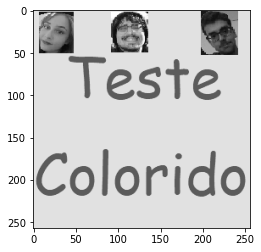

Imagem descomprimida


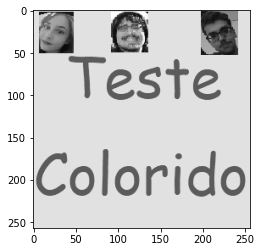

In [34]:
testCompressDecompress('waveletAll', 'colorida.png', 'colorida.bin')

## Apêndice

### Exemplo de codificação e decodificação WaveletAll99

Compression Rate -  7.391631657597203
PSNR -  6.12718002455299
Imagem a ser comprimida


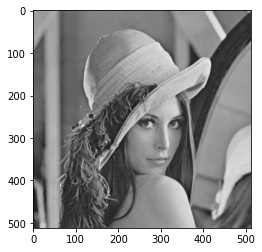

Imagem descomprimida


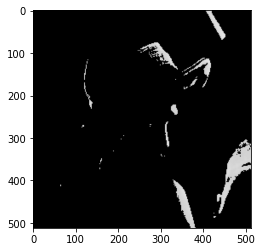

In [35]:
testCompressDecompress('waveletAll', 'img/lena512.pgm', 'tmp/lena512_comp.bin', 99)

### Exemplo de codificação e decodificação Wavelet90

Compression Rate -  1.920705394494875
PSNR -  39.45174367410064
Imagem a ser comprimida


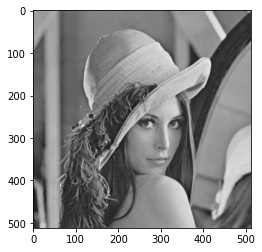

Imagem descomprimida


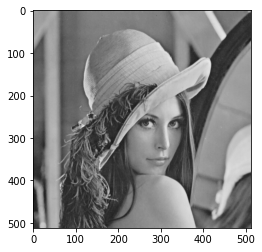

In [36]:
testCompressDecompress('wavelet', 'img/lena512.pgm', 'tmp/lena512_comp.bin', 90)

### Exemplo de codificação e decodificação JPEG com DCT

Compression Rate -  5.346582913548018
PSNR -  36.165662431167085
Imagem a ser comprimida


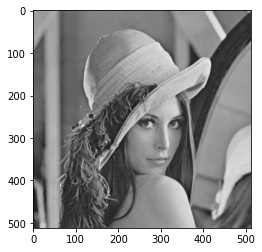

Imagem descomprimida


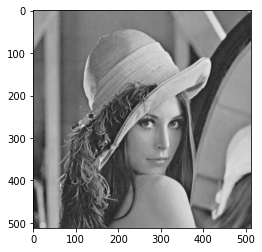

In [37]:
testCompressDecompress('jpegDCT', 'img/lena512.pgm', 'tmp/lena512_comp.bin')

### Exemplo de codificação e decodificação JPEG com DST

Compression Rate -  4.577917088673908
PSNR -  31.385404939384042
Imagem a ser comprimida


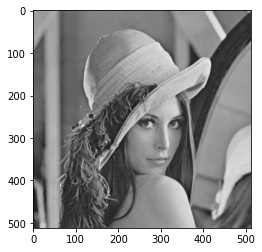

Imagem descomprimida


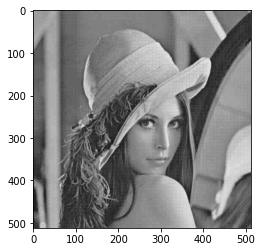

In [38]:
testCompressDecompress('jpegDST', 'img/lena512.pgm', 'tmp/lena512_comp.bin')